In [97]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
import os
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from sklearn import datasets
from keras.layers import Dense, Dropout, LSTM, Activation
import tensorflow as tf
from tensorflow import keras

In [2]:
cwd = os.getcwd()
#Importing both test and train datasets
df_test_FD001 = pd.read_csv(os.path.join(cwd,"test_FD001.txt"), sep=' ', header=None)
df_train_FD001 = pd.read_csv(os.path.join(cwd,"train_FD001.txt"), sep=' ', header=None)

truth_df = pd.read_csv(os.path.join(cwd,"RUL_FD001.txt"), sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
true_rul = pd.read_csv(os.path.join(cwd,"RUL_FD001.txt"), sep="\s+", header=None)
# truth_df.head()

# dropping NAN values
df_test_FD001 = df_test_FD001.dropna(axis=1, how='all')
df_train_FD001 = df_train_FD001.dropna(axis=1, how='all')

# Naming the columns
column_names = ["unit", "cycles", "Op1","Op2", "Op3", "S1", "S2","S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10", 
                "S11","S12", "S13", "S14", "S15", "S16", "S17", "S18", "S19", "S20", "S21"]

df_test_FD001.columns = column_names
df_train_FD001.columns = column_names

# data preprocessing; removing unnecessary data
columns_to_delete = ['Op1','Op2','Op3','S1','S5','S6','S10','S16','S18','S19']

df_test_FD001.drop(columns_to_delete, axis=1, inplace=True)
df_train_FD001.drop(columns_to_delete, axis=1, inplace=True)

# test dataset begins with unit 101 to differentiate from the train dataset
df_test_FD001['unit'] += 100

# Combine the two datasets into a single dataframe
df_combined = pd.concat([df_train_FD001, df_test_FD001]) 

# Perform scalling on the the combined dataset so that their scale is the same
scaler = MinMaxScaler(feature_range = (-1,1))
df_combined.iloc[:,2:18] = scaler.fit_transform(df_combined.iloc[:,2:18])

# Split them again after performing scalling
df_train_FD001 = df_combined[(df_combined.unit <= 100)]
df_test_FD001 = df_combined[(df_combined.unit >= 101)]

# After separation, the first unit of the test dataset is reset to 0 again
df_test_FD001['unit'] -= 100

In [3]:
# Finding the maximum cycle of an engine unit which is used to find its Remaining Useful Life (RUL)
df_train_FD001 = pd.merge(df_train_FD001, df_train_FD001.groupby('unit', as_index=False)['cycles'].max(), how='left', on='unit')
df_train_FD001.rename(columns={"cycles_x": "cycles", "cycles_y": "Final Cycle"}, inplace=True)
df_train_FD001['RUL'] = df_train_FD001['Final Cycle'] - df_train_FD001['cycles']


df_test_FD001 = pd.merge(df_test_FD001, df_test_FD001.groupby('unit', as_index=False)['cycles'].max(), how='left', on='unit')
df_test_FD001.rename(columns={"cycles_x": "cycles", "cycles_y": "Final Cycle"}, inplace=True)


# generate column max for test data
rul = pd.DataFrame(df_test_FD001.groupby('unit')['cycles'].max()).reset_index()
rul.columns = ['unit', 'max']
truth_df.columns = ['more']
truth_df['unit'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
df_test_FD001 = df_test_FD001.merge(truth_df, on=['unit'], how='left')
df_test_FD001['RUL'] = df_test_FD001['max'] - df_test_FD001['cycles']
df_test_FD001.drop('max', axis=1, inplace=True)
# df_test_FD001.head()

In [5]:
df_train_FD001.shape

(20631, 18)

In [6]:
df_test_FD001.shape

(13096, 18)

In [11]:
# Defining train values that will be used to train the machine learning model
X_train = df_train_FD001[[ 'S2', 'S3', 'S4', 'S7', 'S8', 'S11', 'S12',
          'S13', 'S14', 'S15', 'S17', 'S20', 'S21']].values
y_train = df_train_FD001[['RUL']].values.ravel()

# Defining test values that will be used to perform prediction based on the trained model
X_test = df_test_FD001[[ 'S2', 'S3', 'S4', 'S7', 'S8', 'S11', 'S12',
          'S13', 'S14', 'S15', 'S17', 'S20', 'S21']].values

y_test = df_test_FD001[['RUL']].values.ravel()

In [20]:
X_train.shape[1]

13

In [13]:
X_test.shape

(13096, 13)

In [10]:
y_train.shape

(20631,)

In [16]:
y_test.shape

(13096,)

In [45]:
models = {}

##  Linear Regression model

In [46]:
from sklearn.linear_model import LinearRegression
lreg_model = LinearRegression()
lreg_model.fit(X_train,y_train)
models['lr'] = lreg_model

## Random Forest Model

In [47]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train,y_train)
models['forest'] = forest_reg

## KNN Regressor Model

In [48]:
from sklearn.neighbors import KNeighborsRegressor

knr_model = KNeighborsRegressor(n_neighbors=12)
knr_model.fit(X_train, y_train)
models['knr'] = knr_model

## Neural Network Model

In [49]:
from keras.models import Sequential
from keras.layers import Dense, Activation
# from keras.wrappers.scikit_learn import KerasRegressor

# Defining Neural Network model
nn_model = Sequential()
nn_model.add(Dense(50, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
nn_model.add(Dense(1, activation='relu'))

# Compiling model
nn_model.compile(loss='mean_squared_error', optimizer='adam')

# Training the Neural Network model
nn_model.fit(X_train, y_train, epochs = 55, shuffle=True, verbose = 0)
models['nn'] = nn_model

In [61]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

def evaluateModel(y_true,y_pred):

    # Calculate mean squared error
    mse = mean_squared_error(y_true, y_pred)

    # Calculate mean absolute error
    mae = mean_absolute_error(y_true, y_pred)

    # Calculate R-squared
    r2 = r2_score(y_true, y_pred)
    
    # Calculate RMSE
    rmse = np.sqrt(mse)
    
    return (mse,mae,rmse,r2)

## Evaluate all models on the training set

In [69]:
names =[]
mses=[]
maes = []
rmses = []
r2s = []

for name,model in models.items():
    predictions = model.predict(X_train)
    mse,mae,rmse,r2 = evaluateModel(y_train,predictions)
    names.append(name.upper())
    mses.append(mse)
    maes.append(mae)
    rmses.append(rmse)
    r2s.append(r2)
    
train_evaluation_results_df = pd.DataFrame({'model name':names,'mse':mses,'mae':maes,'rmse':rmses,'r2':r2s})

645/645 [==============================] - 1s 1ms/step


In [70]:
train_evaluation_results_df.sort_values(by='rmse')

,model name,mse,mae,rmse,r2
1,FOREST,245.633150,11.005064,15.672688,0.948226
2,KNR,1654.721937,29.206203,40.678274,0.651223
3,NN,1734.155500,29.840031,41.643193,0.634481
0,LR,1998.595779,34.139490,44.705657,0.578743


## Evaluate all models on the test set

In [71]:
names =[]
mses=[]
maes = []
rmses = []
r2s = []

for name,model in models.items():
    predictions = model.predict(X_test)
    mse,mae,rmse,r2 = evaluateModel(y_test,predictions)
    names.append(name.upper())
    mses.append(mse)
    maes.append(mae)
    rmses.append(rmse)
    r2s.append(r2)
    
test_evaluation_results_df = pd.DataFrame({'model name':names,'mse':mses,'mae':maes,'rmse':rmses,'r2':r2s})

410/410 [==============================] - 1s 2ms/step


In [72]:
test_evaluation_results_df.sort_values(by='rmse')

,model name,mse,mae,rmse,r2
3,NN,2113.125093,34.708119,45.968740,0.392499
1,FOREST,2176.508180,35.320006,46.653062,0.374277
0,LR,2344.509189,37.187946,48.420132,0.325978
2,KNR,2401.587208,37.468604,49.005992,0.309569


# LSTM

In [73]:
def process_input_data_with_targets(input_data, target_data=None, window_length=1, shift=1):
    """Depending on values of window_length and shift, this function generates batchs of data and targets 
    from input_data and target_data.    
        Number of batches = np.floor((len(input_data) - window_length)/shift) + 1    
    **We don't check input dimensions uisng exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is 
    produced as output.**    
    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)s
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of 
               29 data points between two consecutive batches.        
    """
    num_batches = int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats=num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets
        

def process_targets(data_length, early_rul=None):
    """ 
    Takes datalength and earlyrul as input and 
    creates target rul.
    """
    if early_rul == None:
        return np.arange(data_laaength-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape=(early_rul_duration,)), np.arange(early_rul-1, -1, -1))
        
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows=1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins.    
    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.    
    The function return last examples and number of last examples (a scaler) as output. 
    We need the second output later. If we are extracting more than 1 last examples, we have to 
    average their prediction results. The second scaler halps us do just that.
    """
    max_num_test_batches = int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine               [-required_len:, :], target_data=None, window_length=window_length, shift=shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :], target_data=None, window_length=window_length, shift=shift)
        return batched_test_data_for_an_engine, num_test_windows

In [91]:
train_data = df_train_FD001
test_data = df_test_FD001

train_feats = df_train_FD001[[ 'S2', 'S3', 'S4', 'S7', 'S8', 'S11', 'S12',
          'S13', 'S14', 'S15', 'S17', 'S20', 'S21']]

test_feats = df_test_FD001[[ 'S2', 'S3', 'S4', 'S7', 'S8', 'S11', 'S12',
          'S13', 'S14', 'S15', 'S17', 'S20', 'S21']]
train_data.head()

,unit,cycles,S2,S3,S4,S7,S8,S9,S11,S12,S13,S14,S15,S17,S20,S21,Final Cycle,RUL
0,1,1,-0.594118,-0.136829,-0.380486,0.452496,-0.492537,-0.780490,-0.225434,0.171598,-0.588235,-0.600784,-0.272028,-0.333333,0.426357,0.403772,192,191
1,1,2,-0.400000,-0.048256,-0.294733,0.256039,-0.552239,-0.799515,-0.202312,0.416174,-0.441176,-0.674373,-0.177376,-0.333333,0.333333,0.416076,192,190
2,1,3,-0.282353,-0.208272,-0.258947,0.420290,-0.432836,-0.719914,-0.456647,0.471400,-0.558824,-0.656414,-0.285110,-0.666667,0.255814,0.203691,192,189
3,1,4,-0.282353,-0.425527,-0.337610,0.481481,-0.343284,-0.750965,-0.618497,0.644970,-0.411765,-0.650222,-0.666795,-0.333333,0.147287,0.283135,192,188
4,1,5,-0.270588,-0.423021,-0.190749,0.336554,-0.492537,-0.700081,-0.445087,0.380671,-0.529412,-0.650532,-0.195845,-0.166667,0.178295,0.364718,192,187


In [92]:
window_length = 30
shift = 1
early_rul = 125            
processed_train_data = []
processed_train_targets = []
# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for 
# each engine is taken. If set to a different number, that many windows from last are taken. 
# Final output is the average output of all windows.

num_test_windows = 5     
processed_test_data = []
num_test_windows_list = []

train_data_first_column = train_data['unit']
test_data_first_column = test_data['unit']

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_feats])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_feats])

# train_data

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.
# Process trianing data

for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values    
    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")        
        
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length=window_length, shift=shift)    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)
processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values    
    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")    
    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length=window_length, shift=shift,
                                                             num_test_windows=num_test_windows)    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)
processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values
# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]
print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

Processed trianing data shape:  (17731, 30, 13)
Processed training ruls shape:  (17731,)
Processed test data shape:  (497, 30, 13)
True RUL shape:  (100,)


In [102]:
def create_compiled_model():
    model = Sequential([
        LSTM(128, input_shape = (window_length, 13), return_sequences=True, activation="tanh"),
        LSTM(64, activation="tanh", return_sequences = True),
        LSTM(32, activation="tanh"),
        Dense(96, activation="relu"),
        Dense(128, activation="relu"),
        Dense(1)
    ])
    model.compile(loss = "mse", optimizer = keras.optimizers.Adam(learning_rate=0.001))
    return model

In [103]:
#use a learning rate scheduler that will decrease the learning rate after 5 epochs
def scheduler(epoch):
    if epoch < 5:
        return 0.001
    else:
        return 0.0001

In [104]:
callback = keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
model = create_compiled_model()
history = model.fit(processed_train_data, processed_train_targets, epochs=10,
                    validation_split=0.10,
                    callbacks=callback, batch_size=128, verbose=2)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
125/125 - 22s - loss: 3465.1768 - val_loss: 1762.8969 - lr: 0.0010 - 22s/epoch - 180ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
125/125 - 15s - loss: 1747.1681 - val_loss: 1763.3562 - lr: 0.0010 - 15s/epoch - 119ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
125/125 - 15s - loss: 1746.7963 - val_loss: 1764.6899 - lr: 0.0010 - 15s/epoch - 120ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
125/125 - 16s - loss: 1719.8203 - val_loss: 1354.4473 - lr: 0.0010 - 16s/epoch - 125ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/10
125/125 - 15s - loss: 394.2481 - val_loss: 224.6621 - lr: 0.0010 - 15s/epoch - 124ms/step

Epoch 6: LearningRateScheduler setting learning rate to 0.0001.
Epoch 6/10
125/125 - 15s - loss: 198.2095 - val_loss: 187.4659 - lr: 1.0000e-04 - 15s/epoch - 121ms/st

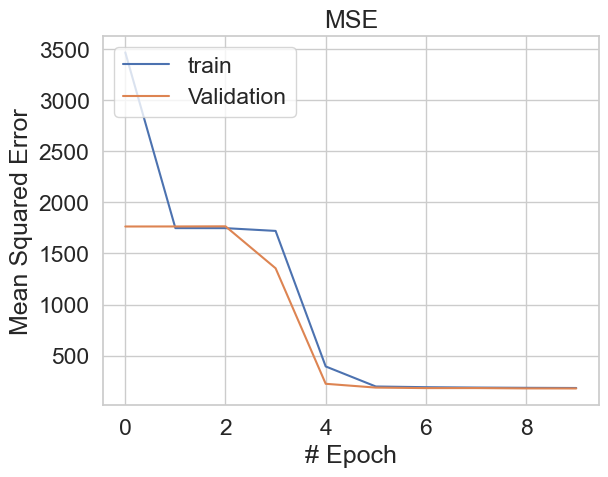

In [105]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MSE')
plt.ylabel('Mean Squared Error')
plt.xlabel('# Epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

## Evaluate LSTM on training set

In [106]:
scores = model.evaluate(processed_train_data, processed_train_targets, verbose=1, batch_size=200)
print('MSE: {}'.format(scores))

89/89 [==============================] - 7s 78ms/step - loss: 181.2608
MSE: 181.26080322265625


In [129]:
y_pred = model.predict(processed_train_data)
y_true = processed_train_targets

mse,mae,rmse,r2 = evaluateModel(y_true,y_pred)

555/555 [==============================] - 12s 21ms/step


In [138]:
# New row as a dictionary
new_row = {'model name': 'LSTM', 'mse': mse, 'mae': mae, 'rmse': rmse, 'r2': r2}
# Concatenate the new row with the existing DataFrame
train_evaluation_results_df = pd.concat([train_evaluation_results_df, pd.DataFrame([new_row])], ignore_index=True)
train_evaluation_results_df.sort_values(by='rmse')

,model name,mse,mae,rmse,r2
4,LSTM,181.260801,9.757440,13.463313,0.896259
5,LSTM,181.260801,9.757440,13.463313,0.896259
1,FOREST,245.633150,11.005064,15.672688,0.948226
2,KNR,1654.721937,29.206203,40.678274,0.651223
3,NN,1734.155500,29.840031,41.643193,0.634481
0,LR,1998.595779,34.139490,44.705657,0.578743


## Evaluate LSTM on test set

In [156]:
rul_pred = model.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])

mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]

16/16 [==============================] - 0s 20ms/step


In [158]:
y_pred_test = mean_pred_for_each_engine
y_true_test = true_rul

mse,mae,rmse,r2 = evaluateModel(y_true_test,y_pred_test)
# New row as a dictionary
new_row = {'model name': 'LSTM', 'mse': mse, 'mae': mae, 'rmse': rmse, 'r2': r2}
# Concatenate the new row with the existing DataFrame
test_evaluation_results_df = pd.concat([test_evaluation_results_df, pd.DataFrame([new_row])], ignore_index=True)
test_evaluation_results_df.sort_values(by='rmse')

,model name,mse,mae,rmse,r2
4,LSTM,240.573697,11.703197,15.510438,0.860688
3,NN,2113.125093,34.708119,45.968740,0.392499
1,FOREST,2176.508180,35.320006,46.653062,0.374277
0,LR,2344.509189,37.187946,48.420132,0.325978
2,KNR,2401.587208,37.468604,49.005992,0.309569


In [159]:
# #We will now compute the RMSE by taking only last example of each engine.
# indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
# preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]
# RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
# print("RMSE (Taking only last examples): ", RMSE_new)

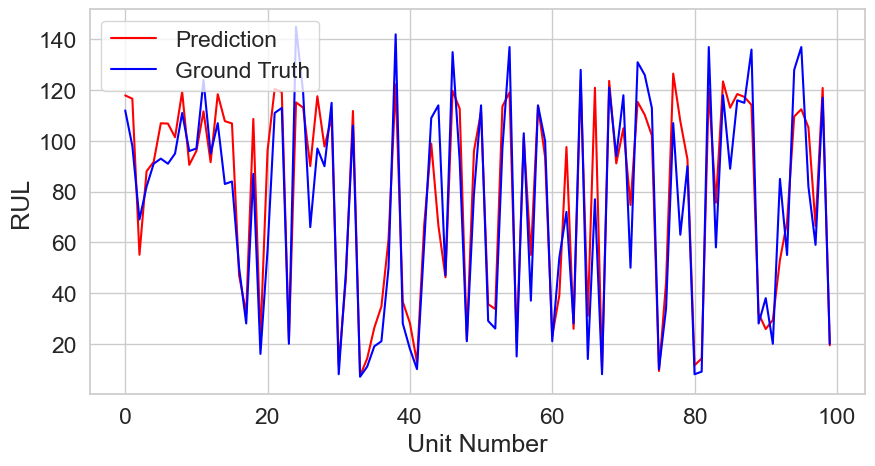

In [160]:
plt.figure(figsize=(10,5))
plt.plot(mean_pred_for_each_engine, color='red', label='Prediction')
plt.plot(true_rul, color='blue', label='Ground Truth')
plt.ylabel("RUL")
plt.xlabel("Unit Number")
plt.legend(loc='upper left')
plt.show()

### Sample Predictions

In [162]:
df = pd.DataFrame({'Actual':true_rul,'Predictions':mean_pred_for_each_engine})
df

,Actual,Predictions
0,112,117.928139
1,98,116.616037
2,69,55.094066
3,82,88.015965
4,91,91.728679
...,...,...
95,137,112.475662
96,82,105.306328
97,59,66.495193
98,117,120.863188
